<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet
#Instalo Fasttext
#!pip install Fasttext

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import tensorflow.keras.callbacks
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model, load_model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from google.colab import drive
#!import fasttext.util
# Montar Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 16.7MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario


In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[28], output_sentences[28], output_sentences_inputs[28]

('hello there', 'hey there how are you  <eos>', '<sos> hey there how are you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
#Obtengo word2idx_inputs

#Agrego preprocesamiento al corpus
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remover puntos (puntuaciones)
    text = re.sub(r'\.', '', text)
    return text

corpus_input_sentences= ''.join(input_sentences)

corpus_input_sentences = np.vectorize(preprocess_text)(corpus_input_sentences)
corpus_input_sentences= np.array([corpus_input_sentences])


num_words = 8000
vocab_size = num_words

#Instancio el tokenizer con el vocab_size sugerido
tokenizer_input = Tokenizer(num_words =8000, oov_token="<UNK>")
tokenizer_input.fit_on_texts(corpus_input_sentences)

word_index_in = tokenizer_input.word_index
word_index_in = {word: index for word, index in word_index_in.items() if index <= 8000}

In [9]:
#Obtengo num_words_input
num_words_input = len(word_index_in)
num_words_input

3073

In [10]:
#Transformo los inputs en secuencias de tokens
tokenized_input = tokenizer_input.texts_to_sequences(input_sentences)
tokenized_input[:10]

[[91],
 [59, 13, 7, 2],
 [59],
 [59],
 [59],
 [68, 7, 2, 387],
 [252],
 [68, 7, 2, 32],
 [4, 9, 32, 503, 30, 2],
 [4, 87, 118, 801, 29, 19, 171]]

In [11]:
#Obtengo max_input_len
max_input_len_idx = np.argmax([len(sentence) for sentence in tokenized_input])
max_input_len = len(tokenized_input[max_input_len_idx])
max_input_len

9

In [12]:
#Obtengo word2idx_outputs

#Agrego preprocesamiento al corpus
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Remover puntos (puntuaciones)
    text = re.sub(r'\.', '', text)
    return text

corpus_output = ''.join(output_sentences)

corpus_output_input = ''.join(output_sentences_inputs)

corpus_output_sentences = corpus_output + corpus_output_input

corpus_output_sentences = np.vectorize(preprocess_text)(corpus_output_sentences)
corpus_output_sentences= np.array([corpus_output_sentences])


num_words = 8000
vocab_size = num_words

#Instancio el tokenizer con el vocab_size sugerido
tokenizer_output = Tokenizer(num_words =8000, oov_token="<UNK>")

# Agrego <sos> y <eos> al vocabulario
sos_token = '<sos>'
eos_token = '<eos>'
tokenizer_output.word_index[sos_token] = len(tokenizer_output.word_index) + 1
tokenizer_output.word_index[eos_token] = len(tokenizer_output.word_index) + 1

tokenizer_output.fit_on_texts(corpus_output_sentences)

word_index_out = tokenizer_output.word_index
word_index_out = {word: index for word, index in word_index_out.items() if index <= 8000}

In [13]:
def index_to_word_output(index, word_index_out):
    """Convierte un índice a una palabra utilizando el diccionario word_index_dict."""
    word = next((word for word, idx in word_index_out.items() if idx == index), None)
    return word

In [14]:
#Transformo los outputs en secuencias de tokens
tokenized_output = tokenizer_output.texts_to_sequences(output_sentences)

#Obtengo max_output_len
max_output_len_idx = np.argmax([len(sentence) for sentence in tokenized_output])
max_output_len = len(tokenized_output[max_output_len_idx])
max_output_len

10

In [15]:
#Obtengo num_words_output
num_words_output = len(word_index_out)
num_words_output

1807

In [16]:
#Obtengo encoder_input_sequences, decoder_output_sequences, decoder_targets
encoder_input_sequences = tokenizer_input.texts_to_sequences(input_sentences)
decoder_output_sequences = tokenizer_output.texts_to_sequences(output_sentences)
decoder_targets = tokenizer_output.texts_to_sequences(output_sentences_inputs)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
#Cargo embeddings preentrenados de Fasttext
# Ruta donde guardo el modelo
model_path = '/content/drive/My Drive/cc.en.300.bin'

# Cargar el modelo
ft = fasttext.load_model(model_path)

In [ ]:
#Genero mi matriz de embeddings en base a los embeddings de fasttext
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in tokenizer_input.word_index.items():
    if word in ft.get_words():
      print(i)
      embedding_matrix[i] = ft.get_word_vector(word)

In [18]:
#Guardo la matriz personalizada de embeddings
#np.save('/content/drive/My Drive/', embedding_matrix_6)

#Cargo la matriz de embeddings
embedding_matrix = np.load('/content/drive/My Drive/embedding_matrix_6.npy')

#Ajusto la matriz de embeddings al tamaño del vocabulario de entrada (la había definido en vocab_size=8000 previamente)
embedding_matrix_6 = embedding_matrix[:3074, :]
embedding_matrix_6.shape

(3074, 300)

In [ ]:
#Realizo el padding
encoder_input_data = pad_sequences(encoder_input_sequences, padding='post')
decoder_input_data = pad_sequences(decoder_targets, padding='post') #Es el decoder target desplazado
decoder_target_data = pad_sequences(decoder_output_sequences, padding='post')
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

In [20]:
#Divido dataset en train y test
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
encoder_input_train, encoder_input_test, \
decoder_input_train, decoder_input_test, \
decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data,
    test_size=0.2, random_state=42,shuffle=True,
)


In [73]:
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense


#Defino el Encoder ---
embedding_size_encoder = 300
#dropout_rate = 0.1
latent_dim = 128
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding = Embedding(input_dim = num_words_input+1,
                              mask_zero=True,
                              output_dim=embedding_size_encoder,
                              input_length=max_input_len,
                              weights=[embedding_matrix_6],  # Asigno los embeddings preentrenados
                              trainable=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_lstm_output, state_h, state_c = encoder_lstm(encoder_embedding)
#encoder_lstm_output = Dropout(dropout_rate)(encoder_lstm_output)  # Capa de Dropout
dense_layer = Dense(64, activation='relu')
encoder_output_dense = dense_layer(encoder_lstm_output)
encoder_states = [state_h, state_c]

# Defino el Decoder
embedding_size_decoder = 300
decoder_inputs = Input(shape=(max_output_len,))
decoder_embedding = Embedding(input_dim=num_words_output+1,
                              mask_zero=True,
                              output_dim=embedding_size_decoder,
                              input_length=max_output_len)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
dense_layer_decoder = Dense(64, activation='relu')
decoder_output_dense = dense_layer_decoder(decoder_outputs)
decoder_dense = Dense(num_words_output+1)
#decoder_outputs = Dropout(dropout_rate)(decoder_outputs)  # Capa de Dropout
decoder_outputs = decoder_dense(decoder_outputs)

# --- Defino el Modelo Seq2Seq Completo ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# --- Compilo el Modelo ---
model.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy',metrics= ['accuracy'])

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [74]:
hist = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    batch_size=64,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    epochs=100
)

Epoch 1/100
76/76 [==============================] - 20s 145ms/step - loss: 9.3714 - accuracy: 0.0674 - val_loss: 7.9801 - val_accuracy: 0.1394
Epoch 2/100
76/76 [==============================] - 3s 40ms/step - loss: 7.0451 - accuracy: 0.1768 - val_loss: 6.8259 - val_accuracy: 0.2020
Epoch 3/100
76/76 [==============================] - 2s 32ms/step - loss: 6.3609 - accuracy: 0.2039 - val_loss: 6.4828 - val_accuracy: 0.2111
Epoch 4/100
76/76 [==============================] - 3s 41ms/step - loss: 6.0802 - accuracy: 0.2099 - val_loss: 6.3227 - val_accuracy: 0.2113
Epoch 5/100
76/76 [==============================] - 3s 42ms/step - loss: 5.9132 - accuracy: 0.2082 - val_loss: 6.2307 - val_accuracy: 0.2075
Epoch 6/100
76/76 [==============================] - 2s 27ms/step - loss: 5.7813 - accuracy: 0.2058 - val_loss: 6.1559 - val_accuracy: 0.2053
Epoch 7/100
76/76 [==============================] - 2s 26ms/step - loss: 5.6754 - accuracy: 0.2038 - val_loss: 6.0718 - val_accuracy: 0.2048
Epoc

In [75]:
model.save('/content/drive/My Drive/Colab Notebooks/Procesamiento del lenguaje natural/model_bot_QA_3.keras')
#model = load_model('/content/drive/My Drive/model_bot_QA.keras')

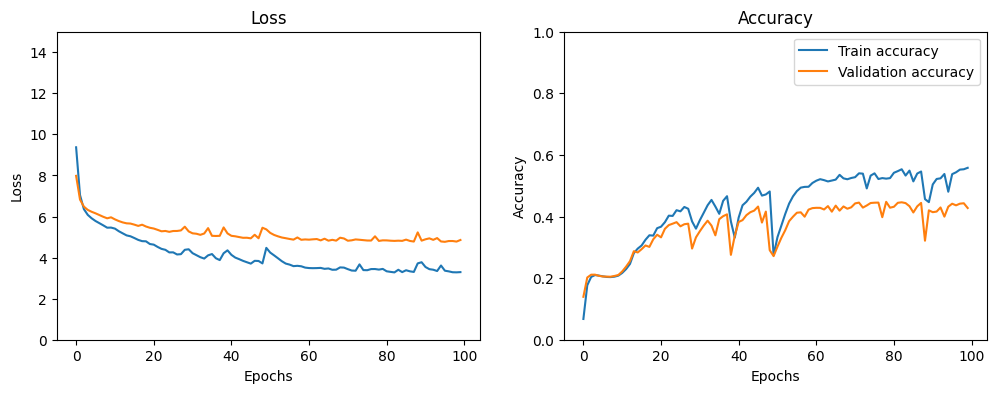

In [76]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']


# Graficar las curvas de precisión
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#Grafico de Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim(0, 15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

#Grafico de Accuracy
plt.subplot(1,2,2)
plt.plot(accuracy, label='Train accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [49]:
def qa_predict(text,model):

    def tokenize_text(text, word_index_in):
        tokens = [word_index_in[word] for word in text.split() if word in word_index_in]
        return tokens

    # Texto de entrada para la inferencia
    input_text = text

    # Tokenizo el texto de entrada
    input_tokens = tokenize_text(input_text, word_index_in)

    # Realizo padding
    input_tokens_padded = pad_sequences([input_tokens], maxlen=max_input_len, padding='post')

    encoder_model = Model(encoder_inputs, encoder_states)

    # Obtener el estado del encoder
    encoder_states_value = encoder_model.predict(input_tokens_padded)

    # Inicializo la secuencia de salida del decoder con una secuencia de inicio
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word_index_out['sos']  # Reemplazar con el índice del token de inicio

    # Decoder para inferencia
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + encoder_states_value)

        # Muestreo estocástico
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word_output(sampled_token_index,word_index_out)

        # Salir del bucle si se alcanza el token de fin o se llega a la longitud máxima
        if sampled_word == 'eos' or len(decoded_sentence) > max_output_len:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        # Actualizar la secuencia de destino para el próximo paso
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar el estado del decoder
        encoder_states_value = [h, c]

    print('Texto de entrada:', input_text)
    print('Texto generado:', decoded_sentence)

In [55]:
text = 'we should rest for a while'
response = qa_predict(text,model)

1/1 [==============================] - 0s 19ms/step
Texto de entrada: we should rest for a while
Texto generado: i m a good 


In [51]:
text2 = 'Do you like to read?'
response = qa_predict(text2,model)

1/1 [==============================] - 0s 19ms/step
Texto de entrada: Do you like to read?
Texto generado: you too 


In [53]:
text3 = 'man...it is so cold'
response = qa_predict(text3,model)

1/1 [==============================] - 0s 34ms/step
Texto de entrada: man...it is so cold
Texto generado: what you do 


In [81]:
text4 = 'i am vegan'
response = qa_predict(text4,model)

1/1 [==============================] - 0s 19ms/step
Texto de entrada: i am vegan
Texto generado: i am 
